# Image Inpainting
Image Inpainting se podría traducir como reconstrucción de una imagen. Este proceso consiste en recuperar zonas pérdidas o dañadas de una imagen. Se puede extender también a videos. 
<table>
    <tr>
        <td><img src="images/example7/linc.jpg"></td> 
        <td><img src="images/example7/linc_verde.png"></td>
        <td><img src="images/example7/rec.png"></td>
    </tr>
     <tr>
        <td><img src="images/example11/torre.jpg"></td> 
        <td><img src="images/example11/torre_mask.png"></td>
        <td><img src="images/example11/rec.png"></td>
    </tr>
    <tr>
    <tr>
        <td><img src="images/example10/orange.png"></td> 
        <td><img src="images/example10/orange_mask.png"></td>
        <td><img src="images/example10/rec.png"></td>
    </tr>
    <tr>
        <td><img src="images/example4/Kanizsa_kiwi.png"></td> 
        <td><img src="images/example4/Kanizsa_kiwi_mask.png"></td>
        <td><img src="images/example4/rec.png"></td>
    </tr>
    
 </table>

OpenCV proporciona dos algoritmos de inpainting. El primer algoritmo se basa en el articulo "An Image Inpainting Technique Based on the Fast Marching Method". 
Para explicar este método consideremos la figura siguiente:
![alt](images/esquema_inpainting1.png)
Debemos rellenar el pixel p situado en la frontera $\delta\Omega$ de la region $\Omega$ que debemos rellenar. Para ello tomamos un vecindario de p $B_\epsilon(p)$ de tamaño $\epsilon$ con pixeles que conocemos su valores. El objetivo es dar un valor p a partir de los valores conocidos de los pixeles próximoas a p. Asi el valor que damos a p viene dado por:
$I(p)=\frac{\sum_{q\in B_\epsilon(p)} w(p,q)|I(q)+\nabla I(q)(p-q)| }{\sum_{q\in B_\epsilon(p)} w(p,q)}$. (eq 1)


La funcion peso $w(p,q)$ se diseña para que propague el nivel de gris correcto asi como la forma de los detalles de la imagen. Los pasos generales serían:
* $\delta \Omega_i $= frontera de la region a rellenar
* $\delta \Omega $=$\delta \Omega_i $
* while ($\delta \Omega $ no este vacia)
    *  p = pixel de $\delta \Omega $ mas proximo a $\delta \Omega_i $
    *  rellenar p usando eq 1
    *  avanzar $\delta \Omega $ en $\Omega $

Se itera los pixeles p de  $\delta \Omega $ atendiendo antes los más próximos a  $\delta \Omega_i $. Hay que tener en cuenta que conforma  $\delta \Omega $ avanza en $\Omega $ la frontera se modifica (es decir $\delta \Omega $). Para propagar o hacer avanzar $\delta \Omega $ en $\Omega$ se usa el fast marching method. 

Sea T la distancia de los pixeles in $\Omega$ a la frontera $\delta\Omega$. El algoritmo fast marching method (FMM) procesa los pixeles de $\delta\Omega$ en orden creciente a la distancia a la frontera (T).
Para mayor de talle de este algoritmo se puede consultar:
An Image Inpainting Technique Based on the Fast Marching Method.Alexandru Telea.

OpenCV tiene implementado este método usando el flag cv.INPAINT_TELEA 



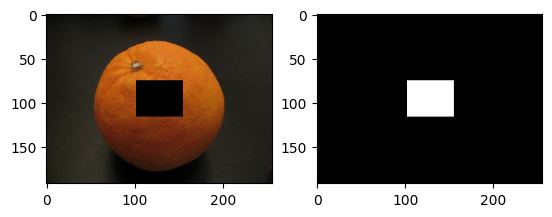

In [141]:
#Ejemplo
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
img = cv.imread('images/example10/orange.png')
img_rgb= cv.cvtColor(img, cv.COLOR_BGR2RGB)
mask = cv.imread('images/example10/orange_mask.png',cv.IMREAD_GRAYSCALE)
mask = 255-mask
#mask= cv.cvtColor(mask, cv.COLOR_GRAYSCALE)
plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.subplot(1,2,2)
plt.imshow(mask,'gray')


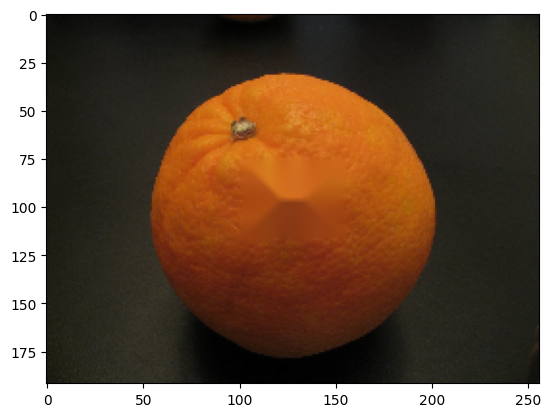

In [142]:
#Aplicamos el proceso de inpainting
rec= cv.inpaint(img,mask,3,cv.INPAINT_TELEA)
rec= cv.cvtColor(rec,cv.COLOR_BGR2RGB)
plt.imshow(rec)


El segundo algoritmo que tiene implementado OpenCV se basa en el articulo 
**"Navier-Stokes, Fluid Dynamics, and Image and Video Inpainting"** by Bertalmio, Marcelo, Andrea L. Bertozzi, and Guillermo Sapiro in 2001. 
La idea subyacente es usar la dinámica de fluido y ecuaciones diferenciales parciales. En primer lugar usando las aristas se trasmiten los pixeles con valores conocidos a regiones desconcidas. Para poder usar este algoritmo se debe usar en OpenCV el flag cv.INPAINT_NS.


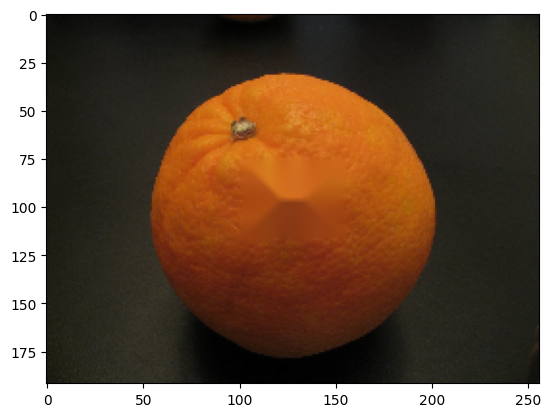

In [143]:
rec2= cv.inpaint(img,mask,3,cv.INPAINT_NS)
rec2= cv.cvtColor(rec2,cv.COLOR_BGR2RGB)
plt.imshow(rec)

## Algoritmo Basado en Parches

El algoritmo que vamos a desarrollar a continuación fue propuesto en **Region Filling and Object Removal by Exemplar-Based Image Inpainting** by A. Criminisi, P. Pérez and K. Toyama. 
La siguiente figura ilustra la idea del algoritmo:
![](esquema_inpainting0.png)
En (a) podemos ver la imagen original, que se compone de una region $\Omega$, su contorno $\delta\Omega$ y la región que esta rellena $\Phi$. En (b) podemos ver un parche centrado en p, $\Psi_p$. Como se puede observar $p \in \delta\Omega$. El objetivo será rellenar el parche $\Psi_p$ de la mejor forma posible.  Como se puede ver en la figura abajo de (a) los mejores candidatos son los parches centrados en $q'$ y $q''$,   $\Psi_{q'}$ y  $\Psi_{q''}$ respectivamente. Como se ve en la figura b abajo el mejor parche se copia en  $\Psi_p$. De esta forma se va reduciendo la region $\Omega$.
![](esquema_inpainting2.png)

Si la  región objetivo es $\Omega$ definimos la región fuente $\Phi=I-\Omega$. Además debemos establecer el tamaño de los parches $\Psi$. Los autores del articulo propusieron un tamaño de $9\times 9$ pixeles.
Además cada pixel tiene un valor de color (si esta en la región fuente o si ha sido ya rellenado , en caso contrario estará vacío) y un valor de confianza, que establece la credibilidad del valor del pixel una vez que ha sido relleno.  Tambien cada pixel que se encuentra en $p \in \delta\Omega$ se define una prioridad 

$P(p)=C(p)D(p)$

siendo $C(p)$ la confianza y $D(p)$ el término data. Asi estos se definen como:

$C(p)=\frac{\sum_{q\in \Psi_p\cap(I-\Omega)}C(q)}{|\Psi_p|}$ (eq1)

$D(p)=\frac{|\nabla I_{p}^{\perp} \cdot n_p|}{\alpha}$ (eq2)


$\alpha$ es una factor de normalización (normalmente puesto a 255). $n_p$ es un vector unidad ortogonal al punto p en la frontera $\delta\Omega$.

En el proceso de inicialización, $C(p)=0 ~\forall p \in \Omega$ y $C(p)=1~\forall p\in I-\Omega$. El término de confianza debe ser entendido como una medida de la cantidad de información creible alrededor del pixel $p$. De esta forma usando C se rellena primero aquellos pixeles rodeados por un mayor de numero de pixels que ya están rellenos (o que son parte de la region fuente).

Una vez establecidas las prioridades para todos los pixeles en $\delta\Omega$, se selecciona el parche $\Psi_p$ con mayor prioridad y lo rellenamos con el mejor parche escogido de $\Phi$.
Para ello se busca un parch $\Phi_q$ que sea mas similar a $\Phi_{\hat{p}}$. De esta forma se escoge:

$\Psi_{\hat{q}}=arg~ min_{\Psi_q \in \Phi} d(\Psi_{\hat{p}},\Psi_q)$


donde la distancia $ d(\Psi_{\hat{p}},\Psi_q)$ es simplemente la suma de las diferencias cuadradas de los pixeles ya rellenos en los parches. 

Despues que el parch $\Psi_{\hat{p}}$ se rellena con los nuevos valores, el valor de confianza $C(p)$ se modifica con 
$C(p)=C(\hat{p}) ~~\forall p \in \Psi_{\hat{p}}\cap\Omega$. 


Por lo tanto el algoritmo realiza los siguientes pasos:
* Definir la region a rellenar y obtener el contorno $\delta \Omega$
* Calcular las prioridades $P(p) ~~\forall p \in \delta\Omega^t$
* Encontrar el parche $\Psi_{\hat{p}}$ con mayor prioridad
* Encontrar el parche $\Psi_{\hat{q}}$ que minimiza $d(\Psi_{\hat{p}},\Psi_q)$
* Copiar $\Psi_{\hat{q}}$ en $\Psi_{\hat{p}}$
* Modificar $C(p) ~\forall p \in \Psi_{\hat{p}}\cap\Omega$





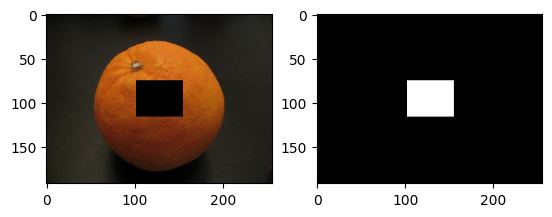

In [144]:
#leemos las imagenes y obtener Omega y dOmega
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
img = cv.imread('images/example10/orange.png')
img_rgb= cv.cvtColor(img, cv.COLOR_BGR2RGB)
mask = cv.imread('images/example10/orange_mask.png',cv.IMREAD_GRAYSCALE)
mask = (255-mask)/255

plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.subplot(1,2,2)
plt.imshow(mask,'gray')


In [145]:

#codigo 
from inpainting_Criminisi.inpainter import Inpainter
output_image = Inpainter(img,mask,
        patch_size=6,
        plot_progress=0
    ).inpaint()
cv.imwrite('orange_fill.png',output_image)


Time to find best: 2.165936 seconds
46985 of 49152 completed
Time to find best: 2.140893 seconds
46991 of 49152 completed
Time to find best: 2.192687 seconds
46997 of 49152 completed
Time to find best: 2.186668 seconds
47003 of 49152 completed
Time to find best: 2.401700 seconds
47009 of 49152 completed
Time to find best: 2.207476 seconds
47015 of 49152 completed
Time to find best: 2.192980 seconds
47021 of 49152 completed
Time to find best: 2.285321 seconds
47027 of 49152 completed
Time to find best: 2.347395 seconds
47033 of 49152 completed
Time to find best: 2.250477 seconds
47039 of 49152 completed
Time to find best: 2.238525 seconds
47045 of 49152 completed
Time to find best: 2.275631 seconds
47051 of 49152 completed
Time to find best: 2.245840 seconds
47057 of 49152 completed
Time to find best: 2.275914 seconds
47063 of 49152 completed
Time to find best: 2.243488 seconds
47069 of 49152 completed
Time to find best: 2.195716 seconds
47075 of 49152 completed
Time to find best: 2.174

True

### EJERCICIO

Sobre las imágenes dadas (example1 a example15) aplicar los tres procedimientos de inpainting. Suponed que la imagen correcta es la imagen rec dada en cada directorio. Medir el error cuadrado medio del resultado que obtiene cada procedimiento de inpainting con la imagen rec dada en cada ejemplo.

 Mostrar gráficas y tablas que comparen los métodos y establezcer el mejor método. 


In [79]:
import cv2 
import os 
import glob
import numpy as np 
import matplotlib.pyplot as plt 

def telea_error(img, mask):
  rec = cv.inpaint(img, mask, 3, cv.INPAINT_TELEA)
  return rec, np.sum((img - rec) ** 2)


def navier_strokes_error(img, mask):
  rec2 = cv.inpaint(img, mask, 3, cv.INPAINT_NS)
  return rec2, np.sum((img - rec2) ** 2)

def criminisi_error(img, mask): 
  from inpainting_Criminisi.inpainter import Inpainter
  output_image = Inpainter(img,mask,
          patch_size=6,
          plot_progress=0
      ).inpaint()
  return output_image, np.sum((img - output_image)**2)

examples = glob.glob("images/**/*.png")
examples.extend(glob.glob("images/**/*.jpg"))
examples = list(filter(lambda x: not x.split('/')[::-1][0].startswith('rec'), examples))
images = list(filter(lambda x: not ("mask" in x or 'verde' in x or 'bungee1' in x), examples))
images = sorted(images, key=lambda x: int(x.split('/')[1].replace('example', '')))
masks = list(filter(lambda x: ("mask" in x or 'verde' in x or 'bungee1' in x), examples))
masks = sorted(masks, key=lambda x: int(x.split('/')[1].replace('example', '')))
print(images)
print(masks)

['images/example1/kanizsa3_2.png', 'images/example2/kanizsa_cuad.png', 'images/example3/torus.png', 'images/example4/Kanizsa_kiwi.png', 'images/example5/bungee0.png', 'images/example6/wedge2.png', 'images/example7/linc.jpg', 'images/example8/test5.png', 'images/example9/ardilla.png', 'images/example10/orange.png', 'images/example11/torre.jpg', 'images/example12/pic-D15.png', 'images/example13/baseball.jpg', 'images/example14/el_org.png', 'images/example15/obs_org.png']
['images/example1/kanizsa3_2_mask.png', 'images/example2/kanizsa_cuad_mask.png', 'images/example3/torus_mask.png', 'images/example4/Kanizsa_kiwi_mask.png', 'images/example5/bungee1.png', 'images/example6/wedge2_mask.png', 'images/example7/linc_verde.png', 'images/example8/test5_mask.png', 'images/example9/ardilla_mask.png', 'images/example10/orange_mask.png', 'images/example11/torre_mask.png', 'images/example12/pic-D15_mask.png', 'images/example13/baseball_mask.png', 'images/example14/el_mask.png', 'images/example15/obs_

Error promedio de reconstrucción: 1876590.4


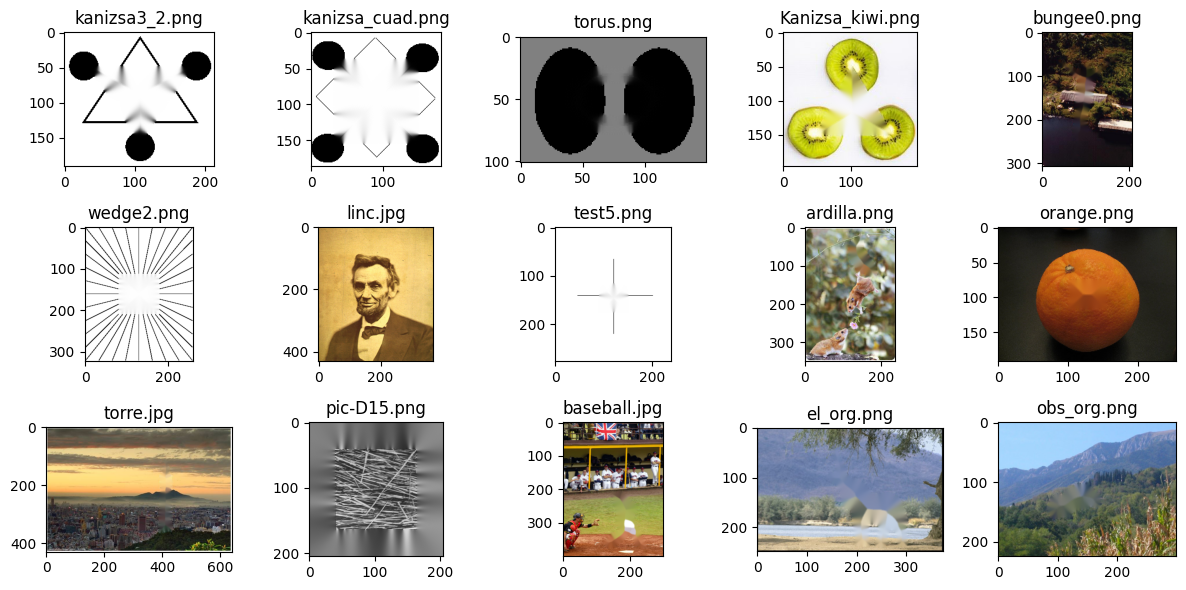

In [133]:
telea_errors = []
telea_rec = []
for imgpath, maskpath in zip(images, masks):
  img = cv2.cvtColor(cv2.imread(imgpath), cv2.COLOR_BGR2RGB)
  mask = cv2.imread(maskpath)
  thr_mask = ( 
    np.where(
      (mask[:, :, 0] == 0) & (mask[:, :, 1] >= 250) & (mask[:, :, 2] == 0),
      255,
      0)
    .astype('uint8')
  )
  if np.count_nonzero(thr_mask) == 0:
    thr_mask = ( 
      np.where(
        (mask[:, :, 0] == 0) & (mask[:, :, 1] == 0) & (mask[:, :, 2] == 0), 
        255,
        0)
      .astype('uint8')
    )
  rec, error = telea_error(img, thr_mask)
  telea_rec.append(rec)
  telea_errors.append(error)

mean_telea = np.mean(telea_errors)
print(f"Error promedio de reconstrucción: {mean_telea}")
fig, ax = plt.subplots(3, 5, tight_layout=True, figsize=(12, 6))
ax = ax.ravel()

for i, rec in enumerate(telea_rec):
  ax[i].imshow(rec)
  ax[i].set_title(os.path.basename(images[i]))
plt.show()

Error promedio de reconstrucción: 2304367.066666667


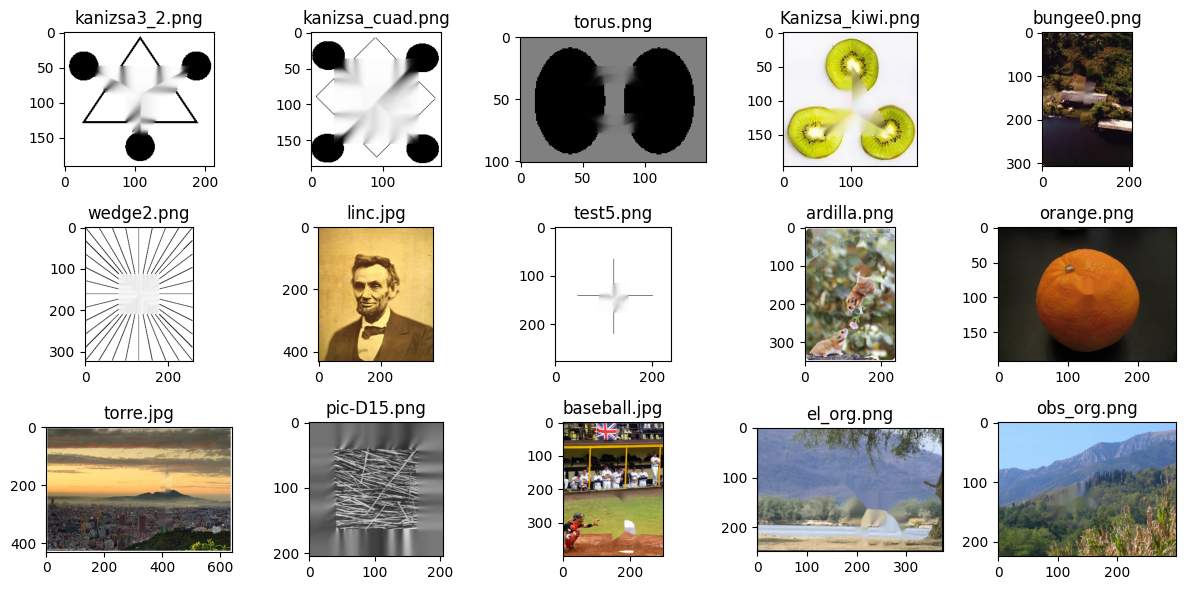

In [134]:
navier_strokes_errors = []
navier_strokes_rec = []
for imgpath, maskpath in zip(images, masks):
  img = cv2.cvtColor(cv2.imread(imgpath), cv2.COLOR_BGR2RGB)
  mask = cv2.imread(maskpath)
  thr_mask = ( 
    np.where(
      (mask[:, :, 0] == 0) & (mask[:, :, 1] >= 250) & (mask[:, :, 2] == 0),
      255,
      0)
    .astype('uint8')
  )
  if np.count_nonzero(thr_mask) == 0:
    thr_mask = ( 
      np.where(
        (mask[:, :, 0] == 0) & (mask[:, :, 1] == 0) & (mask[:, :, 2] == 0), 
        255,
        0)
      .astype('uint8')
    )
  rec, error = navier_strokes_error(img, thr_mask)
  navier_strokes_rec.append(rec)
  navier_strokes_errors.append(error)

mean_navier_strokes = np.mean(navier_strokes_errors)
print(f"Error promedio de reconstrucción: {mean_navier_strokes}")
fig, ax = plt.subplots(3, 5, tight_layout=True, figsize=(12, 6))
ax = ax.ravel()

for i, rec in enumerate(navier_strokes_rec):
  ax[i].imshow(rec)
  ax[i].set_title(os.path.basename(images[i]))
plt.show()

In [135]:
criminisi_errors = []
criminisi_rec = []
for imgpath, maskpath in zip(images, masks):
  img = cv2.cvtColor(cv2.imread(imgpath), cv2.COLOR_BGR2RGB)
  mask = cv2.imread(maskpath)
  thr_mask = ( 
    np.where(
      (mask[:, :, 0] == 0) & (mask[:, :, 1] >= 250) & (mask[:, :, 2] == 0),
      255,
      0)
    .astype('uint8')
  )
  if np.count_nonzero(thr_mask) == 0:
    thr_mask = ( 
      np.where(
        (mask[:, :, 0] == 0) & (mask[:, :, 1] == 0) & (mask[:, :, 2] == 0), 
        255,
        0)
      .astype('uint8')
    )
  rec, error = criminisi_error(img, thr_mask)
  criminisi_rec.append(rec)
  criminisi_errors.append(error)

mean_criminisi = np.mean(criminisi_errors)
print(f"Error promedio de reconstrucción: {mean_criminisi}")
fig, ax = plt.subplots(3, 5, tight_layout=True, figsize=(12, 6))
ax = ax.ravel()

for i, rec in enumerate(criminisi_rec):
  ax[i].imshow(rec)
  ax[i].set_title(os.path.basename(images[i]))
plt.show()

Time to find best: 1.655989 seconds
18446744073707440354 of 40683 completed


/home/briansenas/Master/VC/inpainting/inpainting_Criminisi/inpainter.py:281: RuntimeWarning: overflow encountered in scalar subtract
  print('%d of %d completed' % (total-remaining, total))


Time to find best: 1.570212 seconds
18446744073707444434 of 40683 completed
Time to find best: 1.524474 seconds
18446744073707446984 of 40683 completed
Time to find best: 1.517732 seconds
18446744073707449534 of 40683 completed
Time to find best: 1.576298 seconds
18446744073707452084 of 40683 completed
Time to find best: 1.436868 seconds
18446744073707454634 of 40683 completed
Time to find best: 1.740065 seconds
18446744073707457184 of 40683 completed
Time to find best: 1.440999 seconds
18446744073707459734 of 40683 completed
Time to find best: 1.106431 seconds
18446744073707461774 of 40683 completed
Time to find best: 1.031250 seconds
18446744073707464834 of 40683 completed
Time to find best: 1.069465 seconds
18446744073707468914 of 40683 completed


KeyboardInterrupt: 

## Ápendice pruebas

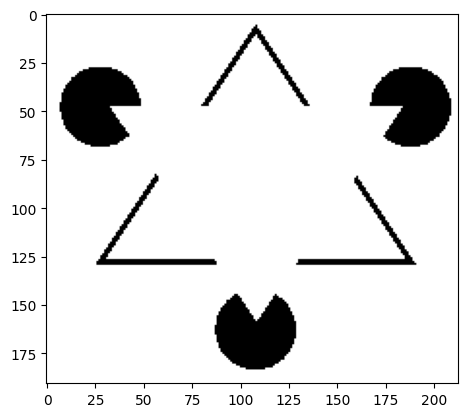

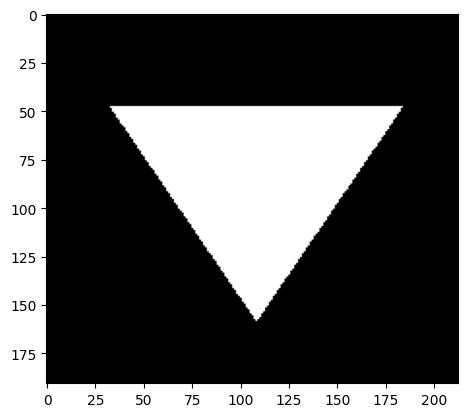

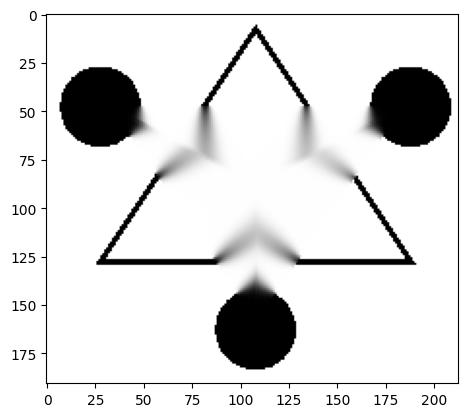

In [138]:
img = cv2.imread(images[0])
plt.imshow(img)
plt.show()
mask = cv2.imread(masks[0])
mask = ( 
  np.where(
    (mask[:, :, 0] == 0) & (mask[:, :, 1] >= 250) & (mask[:, :, 2] == 0),
    255,
    0)
  .astype('uint8')
)
if np.count_nonzero(mask) == 0:
  mask = ( 
    np.where(
      (mask[:, :, 0] == 0) & (mask[:, :, 1] == 0) & (mask[:, :, 2] == 0), 
      255,
      0)
    .astype('uint8')
  )
plt.imshow(mask, 'gray')
plt.show()
rec, error = telea_error(img, mask)
plt.imshow(rec)

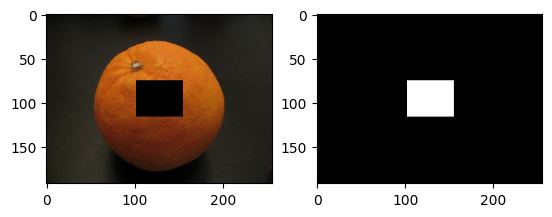

In [132]:
#leemos las imagenes y obtener Omega y dOmega
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
img = cv.imread('images/example10/orange.png')
img_rgb= cv.cvtColor(img, cv.COLOR_BGR2RGB)
mask = cv.imread('images/example10/orange_mask.png')
mask = ( 
  np.where(
    (mask[:, :, 0] == 0) & (mask[:, :, 1] >= 250) & (mask[:, :, 2] == 0),
    255,
    0)
  .astype('uint8')
)
if np.count_nonzero(mask) == 0:
  mask = cv.imread('images/example10/orange_mask.png')
  mask = ( 
    np.where(
      (mask[:, :, 0] == 0) & (mask[:, :, 1] == 0) & (mask[:, :, 2] == 0), 
      255,
      0)
    .astype('uint8')
  )


plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.subplot(1,2,2)
plt.imshow(mask,'gray')


Time to find best: 1.512030 seconds
18446744073707440354 of 40683 completed


/home/briansenas/Master/VC/inpainting/inpainting_Criminisi/inpainter.py:281: RuntimeWarning: overflow encountered in scalar subtract
  print('%d of %d completed' % (total-remaining, total))


Time to find best: 1.573309 seconds
18446744073707444434 of 40683 completed
Time to find best: 1.611043 seconds
18446744073707446984 of 40683 completed
Time to find best: 1.579604 seconds
18446744073707449534 of 40683 completed
Time to find best: 1.551992 seconds
18446744073707452084 of 40683 completed
Time to find best: 1.513414 seconds
18446744073707454634 of 40683 completed
Time to find best: 1.567244 seconds
18446744073707457184 of 40683 completed
Time to find best: 1.500505 seconds
18446744073707459734 of 40683 completed
Time to find best: 1.600054 seconds
18446744073707461774 of 40683 completed
Time to find best: 1.124870 seconds
18446744073707464834 of 40683 completed
Time to find best: 1.726731 seconds
18446744073707468914 of 40683 completed
Time to find best: 1.517911 seconds
18446744073707472229 of 40683 completed
Time to find best: 1.886731 seconds
18446744073707475289 of 40683 completed
Time to find best: 1.742645 seconds
18446744073707478349 of 40683 completed
Time to find

KeyboardInterrupt: 

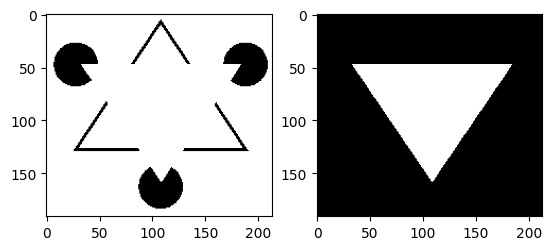

In [140]:
#leemos las imagenes y obtener Omega y dOmega
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
img = cv.imread('images/example1/kanizsa3_2.png')
img_rgb= cv.cvtColor(img, cv.COLOR_BGR2RGB)
mask = cv.imread('images/example1/kanizsa3_2_mask.png')
mask = ( 
  np.where(
    (mask[:, :, 0] == 0) & (mask[:, :, 1] >= 250) & (mask[:, :, 2] == 0),
    255,
    0)
  .astype('uint8')
)
if np.count_nonzero(mask) == 0:
  mask = cv.imread('images/example10/orange_mask.png')
  mask = ( 
    np.where(
      (mask[:, :, 0] == 0) & (mask[:, :, 1] == 0) & (mask[:, :, 2] == 0), 
      255,
      0)
    .astype('uint8')
  )


plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.subplot(1,2,2)
plt.imshow(mask,'gray')
rec, error = criminisi_error(img, mask)
plt.imshow(rec)

Telea resulta obtener el menor error cuadrático medio, con el segundo siendo Navier-Strokes. El método de Criminisi no se ha podido ejecutar por problemas computacionales (el ejemplo de la naranja ha tardado 10 minutos). Estimo que más o menos tardaría 150 minutos ejecutar todos. Por ese factor se ha descalificado de esta competición. 

No obstante, es cierto que si no fuera por esa dificultad computacional este método parece poseer la mejor reconstrucción (al menos para el ejemplo de la naranja).

In [149]:
orange = cv2.imread("images/example10/orange.png")
orange_criminisi = cv2.imread("orange_fill.png")

print(f"Error telea: {telea_errors[10]}")
print(f"Error navier-strokes: {navier_strokes_errors[10]}")
print(f"Error criminisi: {np.sum((orange - orange_criminisi)**2)}")

Error telea: 2879620
Error navier-strokes: 2875444
Error criminisi: 751162
